In [1]:
import os
import h5py
import json, codecs
import PIL
from PIL import Image
import numpy as np
import torch
import torch.nn as nn
from torch.hub import load_state_dict_from_url
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
from pathlib import Path
import random
import glob
import time
import copy


from matplotlib.patches import Rectangle
from skimage import io, transform

from skimage.transform import resize
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [2]:
np.set_printoptions(precision=2)
import pandas as pd
from IPython.display import display, HTML

In [3]:
def get_boxes(path, index, f):
    boxes = []
    labels = np.asarray([])
    bbox_data = f["/digitStruct/bbox"]
    n_boxes = f[bbox_data[index][0]]["label"].len()
    image_path = ""
    if(n_boxes == 1):
        box = {}
        box['height'] = f[bbox_data[index][0]]["height"][0][0]
        box['label'] = f[bbox_data[index][0]]["label"][0][0]
        labels = np.append(labels,0) if (box['label'] == 10) else np.append(labels,box['label'])
        box['left'] = f[bbox_data[index][0]]["left"][0][0]
        box['top'] = f[bbox_data[index][0]]["top"][0][0]
        box['width'] = f[bbox_data[index][0]]["width"][0][0]
        box['name'] = str(index+1) + ".png"
        image_path = str(index+1) + ".png"
        boxes.append(box)
    else:
        for i in range(n_boxes):
            box = {}
            box['height'] = f[f[bbox_data[index][0]]["height"][i][0]][()][0][0]
            box['label'] = f[f[bbox_data[index][0]]["label"][i][0]][()][0][0]
            labels = np.append(labels,0) if (box['label'] == 10) else np.append(labels,box['label'])
            box['left'] = f[f[bbox_data[index][0]]["left"][i][0]][()][0][0]
            box['top'] = f[f[bbox_data[index][0]]["top"][i][0]][()][0][0]
            box['width'] = f[f[bbox_data[index][0]]["width"][i][0]][()][0][0]
            box['name'] = str(index+1) + ".png"
            image_path = str(index+1) + ".png"
            boxes.append(box)
    image = io.imread(os.path.join(path,image_path))
    bounds = get_borders(boxes)
    y1 = int(bounds[1]) if int(bounds[1])>=0 else 0
    x1 = int(bounds[3]) if int(bounds[3])>=0 else 0
    y2 = int(bounds[0]) if int(bounds[0])>=0 else 0
    x2 = int(bounds[2]) if int(bounds[2])>=0 else 0
    image = image[y1:x1, y2:x2]
    
    image = np.multiply(resize(image, (64, 64)),255.0).tolist()
    for i in range(5 - len(labels)):
        labels = np.insert(labels, 0, 10, 0)
    #image = torch.from_numpy(image)
    #labels = torch.tensor(labels)
    return image,labels,boxes

In [4]:
def load_SVHN(folder_path):
    json_file = {}
    print("loading data from "+folder_path)
    nh5 = len(glob.glob1(folder_path,"*.h5"))
    try:
        imgs, lbls  = read_many_hdf5(folder_path, 0)
        for i in range(1,nh5):
            images, labels  = read_many_hdf5(folder_path, i)
            imgs = np.append(imgs,images, axis=0)
            lbls = np.append(lbls,labels, axis=0)
        data = [imgs,lbls]
    except:
        print("Archivo no existe, generando nuevos datos ...")
        data = read_data(folder_path)
    return data

In [5]:
def read_data(path):
    with h5py.File(path+"/digitStruct.mat", "r") as f:    
        n_data = f["/digitStruct/bbox"].len()
        img_data = []
        lbl_data = []
        n=0
        print("creando archivo de imagenes")
        for i in range(n_data):
            image, label, boxes = get_boxes(path, i, f)
            if(len(boxes)<=5):
                img_data.append(image)
                lbl_data.append(label)
            if(i%10000==9999):
                print("guardando archivo de iamgenes....")
                store_many_hdf5(img_data, lbl_data, path, n)
                img_data = []
                lbl_data = []
                n = n + 1
        store_many_hdf5(img_data, lbl_data, path, n)
        
        return img_data

In [6]:
def store_many_hdf5(images, labels, path, name):
    """ Stores an array of images to HDF5.
        Parameters:
        ---------------
        images       images array, (N, 32, 32, 3) to be stored
        labels       labels array, (N, 1) to be stored
    """
    hdf5_dir = Path(path)
    hdf5_dir.mkdir(parents=True, exist_ok=True)
    num_images = len(images)

    # Create a new HDF5 file
    file = h5py.File(hdf5_dir / f"{name}.h5", "w")

    # Create a dataset in the file
    dataset = file.create_dataset(
        "images", np.shape(images), h5py.h5t.STD_U8BE, data=images
    )
    meta_set = file.create_dataset(
        "meta", np.shape(labels), h5py.h5t.STD_U8BE, data=labels
    )
    file.close()

In [7]:
def read_many_hdf5(path, name):
    """ Reads image from HDF5.
        Parameters:
        ---------------
        num_images   number of images to read

        Returns:
        ----------
        images      images array, (N, 32, 32, 3) to be stored
        labels      associated meta data, int label (N, 1)
    """
    hdf5_dir = Path(path)
    hdf5_dir.mkdir(parents=True, exist_ok=True)
    images, labels = [], []

    # Open the HDF5 file
    file = h5py.File(hdf5_dir / f"{name}.h5", "r+")

    images = np.array(file["/images"]).astype("uint8")
    labels = np.array(file["/meta"]).astype("uint8")

    return images, labels

In [8]:
def get_borders(img_data):
    x1 = 9999999
    y1 = 9999999
    x2 = 0
    y2 = 0
    for box in img_data:
        if(box["top"]<y1): y1 = box["top"] 
        if(box["left"]<x1): x1 = box["left"]
        if(box["top"] + box["height"] > y2): y2 = box["top"] + box["height"]
        if(box["left"] + box["width"] > x2): x2 = box["left"] + box["width"]

    return [x1, y1, x2, y2]

In [9]:
class svhn_dataset(Dataset):
    def __init__(self, folder_path, transform = None):
        self.folder_path = folder_path
        self.data = load_SVHN(folder_path=folder_path)
        self.transform = transform
    def __len__(self):
        return len(self.data[1])
    def __getitem__(self, idx):
        #image = np.moveaxis(self.data[0][idx], -1, 0)
        image = self.data[0][idx]
        labels = self.data[1][idx]
        if(self.transform):
            image = self.transform(image)
        sample = {"image": image, "labels": torch.tensor(labels)}
        return(sample)


In [10]:
class toPIL(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, image):
        # swap color axis because
        # numpy image: C x H x W
        # torch image: C X H X W
        #image = image.transpose((2, 0, 1))
        # print(other[0]["name"],labels)
        image = Image.fromarray(image, mode="RGB")
        
        #image = TF.normalize(image,mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
        return image

In [11]:
test_dataset = svhn_dataset("./data/SVHN/test",transform=transforms.Compose([transforms.ToTensor(),
                                                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])]))

loading data from ./data/SVHN/test


In [12]:
train_dataset = svhn_dataset("./data/SVHN/train",transform=transforms.Compose([toPIL(),
                                                                               transforms.RandomChoice([
                                                                                   transforms.ColorJitter(brightness=[0.5,0.8],
                                                                                                          contrast=[0.4,0.5],
                                                                                                          saturation=[0,1]),
                                                                                   transforms.RandomRotation(degrees=30)
                                                                               ]),
                                                                               transforms.ColorJitter(hue=[-0.5,0.5]),
                                                                               transforms.ToTensor(),
                                                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                                              ]))

loading data from ./data/SVHN/train


In [13]:
extra_dataset = svhn_dataset("./data/SVHN/extra",transform=transforms.Compose([
                                                                               transforms.ToTensor(),
                                                                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
                                                                              ]))

loading data from ./data/SVHN/extra


In [14]:
train_loader = DataLoader(train_dataset, batch_size = 256, num_workers = 0, shuffle = True, drop_last = True)
validation_loader = DataLoader(test_dataset, batch_size = 256, num_workers = 0, shuffle = True, drop_last = True)
test_loader = DataLoader(extra_dataset, batch_size = 128, num_workers = 0, shuffle = True, drop_last = True)

In [15]:
print("training set has {} batches ".format(len(train_loader)))
print("validation set has {} batches ".format(len(validation_loader)))
print("test set has {} batches ".format(len(test_loader)))

training set has 130 batches 
validation set has 51 batches 
test set has 1580 batches 


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor([[[-1.2445, -1.2274, -1.2274,  ..., -1.3302, -1.3302, -1.3130],
         [-1.2445, -1.2274, -1.2274,  ..., -1.3302, -1.3302, -1.3302],
         [-1.2445, -1.2274, -1.2274,  ..., -1.3302, -1.3302, -1.3302],
         ...,
         [-1.2445, -1.2274, -1.2274,  ..., -1.3644, -1.3473, -1.3302],
         [-1.2617, -1.2445, -1.2274,  ..., -1.3473, -1.3302, -1.3302],
         [-1.2617, -1.2445, -1.2274,  ..., -1.3473, -1.3302, -1.3130]],

        [[-1.1078, -1.0903, -1.0728,  ..., -1.2129, -1.1954, -1.1779],
         [-1.1078, -1.0903, -1.0728,  ..., -1.2304, -1.1954, -1.1779],
         [-1.1078, -1.0728, -1.0728,  ..., -1.2304, -1.1954, -1.1779],
         ...,
         [-1.0903, -1.0728, -1.0728,  ..., -1.1779, -1.1779, -1.1604],
         [-1.0903, -1.0903, -1.0728,  ..., -1.1779, -1.1604, -1.1429],
         [-1.0903, -1.0903, -1.0903,  ..., -1.1604, -1.1429, -1.1253]],

        [[-0.8981, -0.8807, -0.8458,  ..., -0.9853, -0.9678, -0.9504],
         [-0.8981, -0.8807, -0.8458,  ..., -1

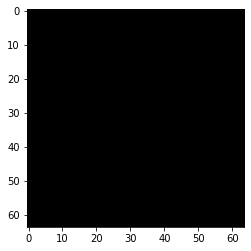

In [16]:
image = train_dataset[26]["image"]
print(image)
plt.figure()
plt.imshow(image.permute(1,2,0))

In [17]:



__all__ = [
    'VGG', 'vgg11', 'vgg11_bn', 'vgg13', 'vgg13_bn', 'vgg16', 'vgg16_bn',
    'vgg19_bn', 'vgg19',
]


model_urls = {
    'vgg11': 'https://download.pytorch.org/models/vgg11-bbd30ac9.pth',
    'vgg13': 'https://download.pytorch.org/models/vgg13-c768596a.pth',
    'vgg16': 'https://download.pytorch.org/models/vgg16-397923af.pth',
    'vgg19': 'https://download.pytorch.org/models/vgg19-dcbb9e9d.pth',
    'vgg11_bn': 'https://download.pytorch.org/models/vgg11_bn-6002323d.pth',
    'vgg13_bn': 'https://download.pytorch.org/models/vgg13_bn-abd245e5.pth',
    'vgg16_bn': 'https://download.pytorch.org/models/vgg16_bn-6c64b313.pth',
    'vgg19_bn': 'https://download.pytorch.org/models/vgg19_bn-c79401a0.pth',
}


class VGG(nn.Module):

    def __init__(self, features, num_classes=11, init_weights=True):
        super(VGG, self).__init__()
        self.features = features
        self.avgpool = nn.AdaptiveAvgPool2d((2, 2))
        self.classifier = nn.Sequential(
            nn.Linear(512 * 2 * 2, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
        )
        self.fcd1 = nn.Linear(4096, num_classes)
        self.fcd2 = nn.Linear(4096, num_classes)
        self.fcd3 = nn.Linear(4096, num_classes)
        self.fcd4 = nn.Linear(4096, num_classes)
        self.fcd5 = nn.Linear(4096, num_classes)
        self.sig1 = nn.LogSoftmax(dim=1)
        self.sig2 = nn.LogSoftmax(dim=1)
        self.sig3 = nn.LogSoftmax(dim=1)
        self.sig4 = nn.LogSoftmax(dim=1)
        self.sig5 = nn.LogSoftmax(dim=1)
        if init_weights:
            self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        dig1 = self.sig1(self.fcd1(x))
        dig2 = self.sig1(self.fcd2(x))
        dig3 = self.sig1(self.fcd3(x))
        dig4 = self.sig1(self.fcd4(x))
        dig5 = self.sig1(self.fcd5(x))
        resp = torch.stack([dig1, dig2, dig3, dig4, dig5],2) 
        return resp

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)


cfgs = {
    'A': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'B': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'D': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'E': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
}


def _vgg(arch, cfg, batch_norm, pretrained, progress, **kwargs):
    if pretrained:
        kwargs['init_weights'] = False
    model = VGG(make_layers(cfgs[cfg], batch_norm=batch_norm), **kwargs)
    if pretrained:
        state_dict = load_state_dict_from_url(model_urls[arch],
                                              progress=progress)
        model.load_state_dict(state_dict)
    return model


def vgg11(pretrained=False, progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") from
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11', 'A', False, pretrained, progress, **kwargs)


def vgg11_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 11-layer model (configuration "A") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg11_bn', 'A', True, pretrained, progress, **kwargs)


def vgg13(pretrained=False, progress=True, **kwargs):
    r"""VGG 13-layer model (configuration "B")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13', 'B', False, pretrained, progress, **kwargs)


def vgg13_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 13-layer model (configuration "B") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg13_bn', 'B', True, pretrained, progress, **kwargs)


def vgg16(pretrained=False, progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16', 'D', False, pretrained, progress, **kwargs)


def vgg16_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 16-layer model (configuration "D") with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg16_bn', 'D', True, pretrained, progress, **kwargs)


def vgg19(pretrained=False, progress=True, **kwargs):
    r"""VGG 19-layer model (configuration "E")
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19', 'E', False, pretrained, progress, **kwargs)


def vgg19_bn(pretrained=False, progress=True, **kwargs):
    r"""VGG 19-layer model (configuration 'E') with batch normalization
    `"Very Deep Convolutional Networks For Large-Scale Image Recognition" <https://arxiv.org/pdf/1409.1556.pdf>`_
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _vgg('vgg19_bn', 'E', True, pretrained, progress, **kwargs)

In [21]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for idx, data in enumerate(dataloaders[phase]):
                inputs = data["image"].to(device, dtype=torch.float)
                labels = data["labels"].to(device, dtype=torch.long)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    
                    _,preds = torch.max(outputs, 1)#outputs.data.max(1, keepdim=False) #outputs.data.max(2, keepdim=False)[1].reshape(-1,5).float()
                    
                   
                    if(idx == 20 and phase == 'val' ):
                        #p = pd.DataFrame(outputs[0,:,:].cpu().detach().numpy())
                        #display(p)
                        print("Predicciones",preds[0,:])
                        print("Real .......",labels[0,:])
                    #_, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += preds.eq(labels).sum() #torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history

In [22]:
# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

scratch_model = vgg11_bn()

# Print the model we just instantiated
print(scratch_model)

params_to_update = scratch_model.parameters()
print("Params to learn:")

for name,param in scratch_model.named_parameters():
    if param.requires_grad == True:
        print("\t",name)

dataloaders_dict = {"train":train_loader,"val":validation_loader}
scratch_model = scratch_model.to(device)
scratch_optimizer = optim.Adam(scratch_model.parameters(), lr=0.0001)
scratch_criterion = nn.CrossEntropyLoss()
_,scratch_hist = train_model(scratch_model, dataloaders_dict, scratch_criterion, scratch_optimizer, num_epochs=150)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU(inplace=True)
    (11): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (12): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (13): ReLU(inplace=True)
    (14): MaxPool2d(ke

val Loss: 0.2047 Acc: 4.7430

Epoch 23/149
----------
train Loss: 0.0775 Acc: 4.8568
Predicciones tensor([10, 10,  1,  4,  8], device='cuda:0')
Real ....... tensor([10, 10,  1,  4,  8], device='cuda:0')
val Loss: 0.1921 Acc: 4.7769

Epoch 24/149
----------
train Loss: 0.0742 Acc: 4.8611
Predicciones tensor([10, 10, 10,  2,  3], device='cuda:0')
Real ....... tensor([10, 10, 10,  2,  3], device='cuda:0')
val Loss: 0.1955 Acc: 4.7678

Epoch 25/149
----------
train Loss: 0.0709 Acc: 4.8679
Predicciones tensor([10, 10, 10,  3,  0], device='cuda:0')
Real ....... tensor([10, 10, 10,  3,  0], device='cuda:0')
val Loss: 0.2167 Acc: 4.7548

Epoch 26/149
----------
train Loss: 0.0656 Acc: 4.8774
Predicciones tensor([10, 10, 10, 10,  5], device='cuda:0')
Real ....... tensor([10, 10, 10, 10,  5], device='cuda:0')
val Loss: 0.1877 Acc: 4.7788

Epoch 27/149
----------
train Loss: 0.0640 Acc: 4.8781
Predicciones tensor([10, 10, 10,  1,  6], device='cuda:0')
Real ....... tensor([10, 10, 10,  1,  6], de

Predicciones tensor([10, 10,  1,  1,  0], device='cuda:0')
Real ....... tensor([10, 10,  1,  1,  0], device='cuda:0')
val Loss: 0.2630 Acc: 4.7724

Epoch 64/149
----------
train Loss: 0.0207 Acc: 4.9479
Predicciones tensor([10, 10, 10,  8,  9], device='cuda:0')
Real ....... tensor([10, 10, 10,  8,  9], device='cuda:0')
val Loss: 0.2496 Acc: 4.7867

Epoch 65/149
----------
train Loss: 0.0231 Acc: 4.9428
Predicciones tensor([10, 10, 10,  3,  9], device='cuda:0')
Real ....... tensor([10, 10, 10,  3,  9], device='cuda:0')
val Loss: 0.2530 Acc: 4.7808

Epoch 66/149
----------
train Loss: 0.0220 Acc: 4.9455
Predicciones tensor([10, 10, 10,  2,  4], device='cuda:0')
Real ....... tensor([10, 10, 10,  2,  4], device='cuda:0')
val Loss: 0.2546 Acc: 4.7785

Epoch 67/149
----------
train Loss: 0.0207 Acc: 4.9470
Predicciones tensor([10, 10, 10,  2,  4], device='cuda:0')
Real ....... tensor([10, 10, 10,  2,  4], device='cuda:0')
val Loss: 0.2483 Acc: 4.7859

Epoch 68/149
----------
train Loss: 0.02

val Loss: 0.2593 Acc: 4.8054

Epoch 104/149
----------
train Loss: 0.0122 Acc: 4.9611
Predicciones tensor([10, 10, 10, 10,  1], device='cuda:0')
Real ....... tensor([10, 10, 10, 10,  7], device='cuda:0')
val Loss: 0.3103 Acc: 4.7865

Epoch 105/149
----------
train Loss: 0.0128 Acc: 4.9605
Predicciones tensor([10, 10, 10,  3,  1], device='cuda:0')
Real ....... tensor([10, 10, 10,  3,  1], device='cuda:0')
val Loss: 0.2769 Acc: 4.7949

Epoch 106/149
----------
train Loss: 0.0131 Acc: 4.9606
Predicciones tensor([10, 10,  2,  3,  9], device='cuda:0')
Real ....... tensor([10, 10,  2,  5,  9], device='cuda:0')
val Loss: 0.2969 Acc: 4.7884

Epoch 107/149
----------
train Loss: 0.0135 Acc: 4.9607
Predicciones tensor([10, 10, 10, 10,  7], device='cuda:0')
Real ....... tensor([10, 10, 10, 10,  7], device='cuda:0')
val Loss: 0.2789 Acc: 4.7893

Epoch 108/149
----------
train Loss: 0.0113 Acc: 4.9627
Predicciones tensor([10, 10,  1,  2,  1], device='cuda:0')
Real ....... tensor([10, 10,  1,  2,  1

train Loss: 0.0076 Acc: 4.9688
Predicciones tensor([10, 10,  5,  0,  7], device='cuda:0')
Real ....... tensor([10, 10,  5,  0,  7], device='cuda:0')
val Loss: 0.2895 Acc: 4.8112

Epoch 145/149
----------
train Loss: 0.0084 Acc: 4.9680
Predicciones tensor([10, 10, 10,  3,  1], device='cuda:0')
Real ....... tensor([10, 10, 10,  3,  7], device='cuda:0')
val Loss: 0.3216 Acc: 4.7984

Epoch 146/149
----------
train Loss: 0.0080 Acc: 4.9698
Predicciones tensor([10, 10, 10,  2,  4], device='cuda:0')
Real ....... tensor([10, 10, 10,  2,  4], device='cuda:0')
val Loss: 0.2935 Acc: 4.8117

Epoch 147/149
----------
train Loss: 0.0090 Acc: 4.9675
Predicciones tensor([10, 10, 10, 10,  5], device='cuda:0')
Real ....... tensor([10, 10, 10, 10,  5], device='cuda:0')
val Loss: 0.2915 Acc: 4.7988

Epoch 148/149
----------
train Loss: 0.0091 Acc: 4.9668
Predicciones tensor([10, 10, 10,  9,  3], device='cuda:0')
Real ....... tensor([10, 10, 10,  3,  3], device='cuda:0')
val Loss: 0.2793 Acc: 4.8071

Epoch

for idx,data in enumerate(train_loader, 0):
    torch.save(data,"./"+str(idx)+"data.pt")
for idx,data in enumerate(validation_loader, 0):
    torch.save(data,"./"+str(idx)+"data_val.pt")

In [23]:
PATH = './svhn_netvgg11_adam.pth'
torch.save(scratch_model.state_dict(), PATH)

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
PATH = './svhn_netvgg11_adam.pth'
model = vgg11_bn()
model = model.to(device)
model.load_state_dict(torch.load(PATH))
model.eval()
correctos = 0.0
incorrectos = 0
total_imagenes = 0
for i, data in enumerate(test_loader,0):
    image = data["image"].to(device, dtype=torch.float)
    label = data["labels"].to(device, dtype=torch.long)
    #draw_boxes(data["image"][0], data["other"])
    totalbatch = len(image)
    total_imagenes += totalbatch
    out = model(image)
    #print(out)
    #print(label)
    _,preds = torch.max(out, 1)
    #print(predicted)
    cor = preds.eq(label).sum()
    #print(predicted.eq(label.float()))
    
    
    correctos += cor
    incorrectos += totalbatch*5 - (cor)
    

In [25]:
print(correctos, incorrectos, total_imagenes)
x = ((correctos.item())/(total_imagenes*5))*100
print("accuracy {}%".format(x))

tensor(933304, device='cuda:0') tensor(77896, device='cuda:0') 202240
accuracy 92.29667721518987%


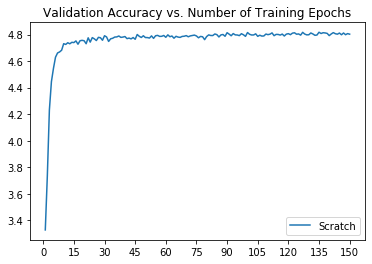

In [32]:
plt.title("Validation Accuracy vs. Number of Training Epochs")
shist = [h.cpu().numpy() for h in scratch_hist]
plt.plot(range(1,150+1),shist,label="Scratch")
plt.xticks(np.arange(0, 151, 15.0))
plt.legend()
plt.show()